In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from plotnine import *


In [3]:
#Prep Data
baseball = pd.read_csv(r"C:\Users\broga\OneDrive\Desktop\MSBA\Computing_ML\Labs\Lab_6\Hitters.csv")
baseball = baseball.dropna()
baseball.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


We are going to analyze different ways/models to predict a quantitative variable using linear, lasso, ridge, and elastic net regression. We are using a baseball dataset to predict salaries based on various baseball statistcs. We learn below about hte benefits of penalized regression models and how elastic net finds the optimal ratio between ridge and lasso regression. We also tune use pipelines, cross-validation, and tuning from the sci-kit learn library to streamline and efficiently choose parameters within models.

# Part I: Different Model Specs

In [3]:
X = baseball.drop('Salary', axis=1)
y = baseball['Salary']
# Identifier for cat and num columns
catCols = X.select_dtypes(include=['object']).columns
numCols = X.select_dtypes(include=['int64', 'float64']).columns

## Regression without regularization

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

In [4]:
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numCols),
        ('cat', OneHotEncoder(), catCols)
    ])

# Creates pipeline
lr_pipeline = Pipeline([
    ('preprocessing', ct),
    ('linear_regression', LinearRegression())
])

# Fit pipline to entire dataset
lr_pipeline.fit(X, y)

# Getting the coefficients from the linear regression model
coefficients = lr_pipeline.named_steps['linear_regression'].coef_
var_names = ct.transformers_[0][2].tolist() +\
            list(ct.named_transformers_['cat'].get_feature_names_out()) #grabs categorical var names

# Combining coefficients with feature names
coeff_names = list(zip(var_names, coefficients))

# Sorting coefficients by their absolute values to find the most impactful ones
coeff_sig = sorted(coeff_names, key=lambda x: abs(x[1]), reverse=True)

# Estimating (MSE) using cross-validation
cv_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
mse_cv = round(-np.mean(cv_scores),4)

top_coeff = pd.DataFrame(coeff_sig[:5], columns=['Variable', 'Coefficient'])

print(top_coeff)
print(f"MSE: {mse_cv}")


  Variable  Coefficient
0    CRuns   480.747135
1   CAtBat  -391.038655
2     Hits   337.830479
3    AtBat  -291.094556
4     CRBI   260.689886
MSE: 121136.3103


The following 3 coefficients were the most important coefficients within the model: Cruns, CAtBat, amd Hits. CRuns and Hits having large positive coefficients makes sense as those are important stats that contribute postively to winning baseball games. CAtBat's having a large negative coefficient is a little bit surprising but I guess it captures the older veteran players that usually take discounted/lower contracts at the end of their playing careers.


## Ridge Regression

In [5]:
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numCols),
        ('cat', OneHotEncoder(), catCols)
    ])

# Creating pipeline
ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)

results = [0.1,1,10,100]

lambdas = {'ridge_regression__alpha': results}

gscv = GridSearchCV(ridge_pipeline, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,0.1,120343.621067
1,1.0,119144.432677
2,10.0,119348.984776
3,100.0,120716.435589


In [6]:
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numCols),
        ('cat', OneHotEncoder(), catCols)
    ])

# Creating pipeline with optimal lambda
ridge_pipeline2 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=1))]
)

# Fit pipline to entire dataset
ridge_pipeline2.fit(X, y)

# Getting the coefficients from the linear regression model
coefficients = ridge_pipeline2.named_steps['ridge_regression'].coef_
var_names = ct.transformers_[0][2].tolist() +\
            list(ct.named_transformers_['cat'].get_feature_names_out()) #grabs categorical var names

# Combining coefficients with feature names
coeff_names = list(zip(var_names, coefficients))

# Sorting coefficients by their absolute values to find the most impactful ones
coeff_sig = sorted(coeff_names, key=lambda x: abs(x[1]), reverse=True)

# Estimating (MSE) using cross-validation
cv_scores = cross_val_score(ridge_pipeline2, X, y, cv=5, scoring='neg_mean_squared_error')
mse_cv = round(-np.mean(cv_scores),4)

top_coeff = pd.DataFrame(coeff_sig[:5], columns=['Variable', 'Coefficient'])

print(top_coeff)
print(f"MSE: {mse_cv}")

  Variable  Coefficient
0    CRuns   320.412169
1     Hits   296.645050
2    AtBat  -270.686441
3   CAtBat  -225.406548
4   CWalks  -184.423611
MSE: 119144.4327


The following 3 coefficients were the most important coefficients within the model: CRuns, Hits, and AtBat. See previous interpretations.

## Lasso Regression

In [7]:
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numCols),
        ('cat', OneHotEncoder(), catCols)
    ])

# Creating pipeline
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(tol=.01))]
)

results = [1,10,100]

lambdas = {'lasso_regression__alpha': results}

gscv = GridSearchCV(lasso_pipeline, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,1,119996.472961
1,10,122422.228759
2,100,143641.550676


In [8]:
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numCols),
        ('cat', OneHotEncoder(), catCols)
    ])

# Creating pipeline with optimal lambda
lasso_pipeline2 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha=1,tol=.01))]
)

# Fit pipline to entire dataset
lasso_pipeline2.fit(X, y)

# Getting the coefficients from the linear regression model
coefficients = lasso_pipeline2.named_steps['lasso_regression'].coef_
var_names = ct.transformers_[0][2].tolist() +\
            list(ct.named_transformers_['cat'].get_feature_names_out()) #grabs categorical var names

# Combining coefficients with feature names
coeff_names = list(zip(var_names, coefficients))

# Sorting coefficients by their absolute values to find the most impactful ones
coeff_sig = sorted(coeff_names, key=lambda x: abs(x[1]), reverse=True)

# Estimating (MSE) using cross-validation
cv_scores = cross_val_score(lasso_pipeline2, X, y, cv=5, scoring='neg_mean_squared_error')
mse_cv = round(-np.mean(cv_scores),4)

top_coeff = pd.DataFrame(coeff_sig[:5], columns=['Variable', 'Coefficient'])

print(top_coeff)
print(f"MSE: {mse_cv}")

  Variable  Coefficient
0    CRuns   316.220873
1     Hits   293.053451
2    AtBat  -277.177325
3   CAtBat  -237.345856
4   CWalks  -182.501286
MSE: 119996.473


The following 3 coefficients were the most important coefficients within the model: CRuns, Hits, and AtBat. See previous interpretations.

## Elastic Net

In [9]:
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numCols),
        ('cat', OneHotEncoder(), catCols)
    ])


# Creating pipeline
enet_pipeline = Pipeline(
  [("preprocessing", ct),
   ("enet_regression", ElasticNet(max_iter=100000, tol=0.1))]
)


lambdas = {
    'enet_regression__alpha': np.linspace(0.01, 1, 10),
    'enet_regression__l1_ratio': np.linspace(0.01, 1, 10)
}

# Using enet_pipeline in GridSearchCV
gscv = GridSearchCV(enet_pipeline, lambdas, cv=5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X,y)

# Extracting results
results = gscv.cv_results_

# Creating a DataFrame
df = pd.DataFrame({
    'alpha': results['param_enet_regression__alpha'],
    'l1_ratio': results['param_enet_regression__l1_ratio'],
    'mean_squared_error': -results['mean_test_score']  
})

results_df = df.sort_values(by='mean_squared_error')
results_df.head(2)

,alpha,l1_ratio,mean_squared_error
18,0.12,0.89,118796.055281
28,0.23,0.89,118886.622540


In [10]:
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numCols),
        ('cat', OneHotEncoder(), catCols)
    ])

# Creating pipeline
enet_pipeline2 = Pipeline(
  [("preprocessing", ct),
  ("enet_regression", ElasticNet(alpha=0.11,l1_ratio=.89))]
)

# Fit pipline to entire dataset
enet_pipeline2.fit(X, y)

# Getting the coefficients from the linear regression model
coefficients = enet_pipeline2.named_steps['enet_regression'].coef_
var_names = ct.transformers_[0][2].tolist() +\
            list(ct.named_transformers_['cat'].get_feature_names_out()) #grabs categorical var names

# Combining coefficients with feature names
coeff_names = list(zip(var_names, coefficients))

# Sorting coefficients by their absolute values to find the most impactful ones
coeff_sig = sorted(coeff_names, key=lambda x: abs(x[1]), reverse=True)

# Estimating (MSE) using cross-validation
cv_scores = cross_val_score(enet_pipeline2, X, y, cv=5, scoring='neg_mean_squared_error')
mse_cv = round(-np.mean(cv_scores),4)

top_coeff = pd.DataFrame(coeff_sig[:5], columns=['Variable', 'Coefficient'])

print(top_coeff)
print(f"MSE: {mse_cv}")

  Variable  Coefficient
0     Hits   235.047403
1    AtBat  -220.137829
2    CRuns   204.999106
3   CWalks  -147.239948
4    CHits   117.952548
MSE: 118956.5999


The following 3 coefficients were the most important coefficients within the model: CRuns, Hits, and AtBat. See previous interpretations.


# Part II. Variable Selection

In [11]:
X = baseball[['Hits','CRBI','CRuns','AtBat','Years','Division']]
y = baseball["Salary"]

## Linear Regression

In [12]:
#LR Only Hits
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits']),
    ], remainder = "drop"
).set_output(transform = "pandas")

# Creates pipeline
lr_pipelineHits = Pipeline([
    ('preprocessing', ct),
    ('linear_regression', LinearRegression())
])

# Fit pipline to entire dataset
lr_pipelineHits.fit(X, y)


scores = cross_val_score(lr_pipelineHits, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"LR Hits Mean Squared Error: {mean_mse}")


LR Hits Mean Squared Error: 173088.97286444032


In [13]:
#LR Top 5
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Years']),
    ], remainder = "drop"
).set_output(transform = "pandas")

# Creates pipeline
lr_pipelineTop5 = Pipeline([
    ('preprocessing', ct),
    ('linear_regression', LinearRegression())
])

# Fit pipline to entire dataset
lr_pipelineTop5.fit(X, y)


scores = cross_val_score(lr_pipelineTop5, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"LR Top 5 Mean Squared Error: {mean_mse}")

LR Top 5 Mean Squared Error: 121965.386779112


In [14]:
# LR Top 5 + Interaction
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ("dummify", OneHotEncoder(sparse_output = False), ["Division"]),
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Years']),
    ], remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["Standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["Standardize__CRBI", "dummify__Division_E"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["Standardize__CRuns", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["Standardize__AtBat", "dummify__Division_E"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["Standardize__Years", "dummify__Division_E"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

# Creates pipeline
lr_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ('linear_regression', LinearRegression())
])

# Fit pipline to entire dataset
lr_pipelineTop5int.fit(X, y)


scores = cross_val_score(lr_pipelineTop5int, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"LR Top 5 + Interact Mean Squared Error: {mean_mse}")

LR Top 5 + Interact Mean Squared Error: 123078.47016346463


The Top5 model (no interaction) performed the best which makes sense intuitively as the interactions between division and the chosen predictors would not add much to the model, and including the 5 most significant variables should produce a better model.

## Ridge Regression

In [15]:
# Ridge Only Hits Tuning
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits']),
    ], remainder = "drop"
).set_output(transform = "pandas")

# Creating pipeline
ridge_pipelineHits = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)

results = [1,10,100]

lambdas = {'ridge_regression__alpha': results}

gscv = GridSearchCV(ridge_pipelineHits, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,1,173046.230311
1,10,172755.975523
2,100,174448.308656


In [16]:
# Ridge Only Hits
# Creating pipeline with optimal lambda
ridge_pipelineHits = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=10))]
)

ridge_pipelineHits.fit(X,y)

scores = cross_val_score(ridge_pipelineHits, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Ridge Reg Hits Mean Squared Error: {mean_mse}")

Ridge Reg Hits Mean Squared Error: 172755.97552343184


In [17]:
#Ridge Top 5 Tuning
#Only Hits
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Years']),
    ], remainder = "drop"
).set_output(transform = "pandas")

# Creating pipeline
ridge_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)

results = [0.1,1,10,100]

lambdas = {'ridge_regression__alpha': results}

gscv = GridSearchCV(ridge_pipelineTop5, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,0.1,121934.974976
1,1.0,121778.986574
2,10.0,122847.118379
3,100.0,128010.789865


In [18]:
#Ridge Top 5

# Creating pipeline with optimal lambda
ridge_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=1))]
)

ridge_pipelineTop5.fit(X,y)

scores = cross_val_score(ridge_pipelineTop5, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Ridge Reg Top5 Mean Squared Error: {mean_mse}")


Ridge Reg Top5 Mean Squared Error: 121778.98657389618


In [19]:
#Ridge Top 5 + Interaction Tuning
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ("dummify", OneHotEncoder(sparse_output = False), ["Division"]),
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Years']),
    ], remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["Standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["Standardize__CRBI", "dummify__Division_E"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["Standardize__CRuns", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["Standardize__AtBat", "dummify__Division_E"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["Standardize__Years", "dummify__Division_E"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

# Creates pipeline
ridge_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ('ridge_regression', Ridge())
])

results = [1,10,100,1000]

lambdas = {'ridge_regression__alpha': results}

gscv = GridSearchCV(ridge_pipelineTop5int, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,1,118417.245434
1,10,115922.255583
2,100,120460.461112
3,1000,147194.772549


In [20]:
#Ridge Top 5 + Interaction

# Creates pipeline
ridge_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ('ridge_regression', Ridge(alpha=10))
])

ridge_pipelineTop5int.fit(X,y)

scores = cross_val_score(ridge_pipelineTop5int, X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Ridge Reg Top5 + Int Mean Squared Error: {mean_mse}")


Ridge Reg Top5 + Int Mean Squared Error: 115922.25558303518


## Lasso Regression

In [21]:
# Lasso Only Hits Tuning
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits']),
    ], remainder = "drop"
).set_output(transform = "pandas")

# Creating pipeline
lasso_pipelineHits = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
)

results = [1,10,100]

lambdas = {'lasso_regression__alpha': results}

gscv = GridSearchCV(lasso_pipelineHits, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,1,173076.934306
1,10,173061.634500
2,100,182120.311402


In [22]:
# Lasso Only Hits

# Creating pipeline with optimal lambda
lasso_pipelineHits = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha=10))]
)

lasso_pipelineHits.fit(X,y)

scores = cross_val_score(lasso_pipelineHits, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Lasso Reg Hits Mean Squared Error: {mean_mse}")

Lasso Reg Hits Mean Squared Error: 173061.63450002926


In [23]:
#Lasso Top 5 Tuning
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Years']),
    ], remainder = "drop"
).set_output(transform = "pandas")

# Creating pipeline
lasso_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
)

results = [.0000001,.000001,.00001,.0001]

lambdas = {'lasso_regression__alpha': results}

gscv = GridSearchCV(lasso_pipelineTop5, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,1.000000e-07,121965.386815
1,1.000000e-06,121965.387148
2,1.000000e-05,121965.388535
3,1.000000e-04,121965.400834


In [24]:
#Lasso Top 5
# Column transformer that standardizes + creates dummies

# Creating pipeline with optimal lambda
lasso_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Lasso(alpha=.000001))]
)

lasso_pipelineTop5.fit(X,y)

scores = cross_val_score(lasso_pipelineTop5, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Lasso Reg Top5 Mean Squared Error: {mean_mse}")


Lasso Reg Top5 Mean Squared Error: 121965.3871482743


In [36]:
#Lasso Top 5 + Interaction Tuning
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ("dummify", OneHotEncoder(sparse_output = False), ["Division"]),
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Years']),
    ], remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["Standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["Standardize__CRBI", "dummify__Division_E"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["Standardize__CRuns", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["Standardize__AtBat", "dummify__Division_E"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["Standardize__Years", "dummify__Division_E"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

# Creates pipeline
lasso_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ('lasso_regression', Lasso())
])

results = [0.1,1,10,100]

lambdas = {'lasso_regression__alpha': results}

gscv = GridSearchCV(lasso_pipelineTop5int, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,0.1,122590.111062
1,1.0,119877.710933
2,10.0,123002.980146
3,100.0,144285.535620


In [38]:
#Lasso Top 5 + Interaction
# Creates pipeline
lasso_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ('Lasso_regression', Lasso(alpha=1))
])

lasso_pipelineTop5int.fit(X,y)

scores = cross_val_score(lasso_pipelineTop5int, X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Lasso Reg Top5 + Int Mean Squared Error: {mean_mse}")


Lasso Reg Top5 + Int Mean Squared Error: 119877.71093255976


## Elastic Net

In [27]:
# Elastic Net Only Hits Tuning
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits']),
    ], remainder = "drop"
).set_output(transform = "pandas")


# Creating pipeline
enet_pipelineHits = Pipeline(
  [("preprocessing", ct),
   ("enet_regression", ElasticNet(max_iter=100000, tol=0.1))]
)

# Define the parameter grid
lambdas = {
    'enet_regression__alpha': np.linspace(0.01, 1, 10),
    'enet_regression__l1_ratio': np.linspace(0.01, 1, 10)
}

# Using enet_pipeline in GridSearchCV
gscv = GridSearchCV(enet_pipelineHits, lambdas, cv=5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X,y)

# Extracting results
results = gscv.cv_results_

# Creating a DataFrame
df = pd.DataFrame({
    'alpha': results['param_enet_regression__alpha'],
    'l1_ratio': results['param_enet_regression__l1_ratio'],
    'mean_squared_error': -results['mean_test_score']  # Negating because scores are negative MSE
})

results_df = df.sort_values(by='mean_squared_error')
results_df.head(3)

,alpha,l1_ratio,mean_squared_error
10,0.12,0.01,172569.569811
24,0.23,0.45,172571.467365
36,0.34,0.67,172578.968935


In [28]:
# Elastic Net Only Hits

# Creating pipeline
enet_pipelineHits = Pipeline(
  [("preprocessing", ct),
   ("enet_regression", ElasticNet(alpha=0.33, l1_ratio=0.67, max_iter=100000, tol=0.1))]
)

enet_pipelineHits.fit(X,y)

scores = cross_val_score(lasso_pipelineHits, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Elastic Net Hits Mean Squared Error: {mean_mse}")

Elastic Net Hits Mean Squared Error: 173061.63450002926


In [29]:
#Elastic Net Top 5 Tuning
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Years']),
    ], remainder = "drop"
).set_output(transform = "pandas")

# Creating pipeline
enet_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
   ("enet_regression", ElasticNet(max_iter=10000, tol=0.1))]
)

# Define the parameter grid
lambdas = {
    'enet_regression__alpha': np.linspace(0.1, 1, 10),
    'enet_regression__l1_ratio': np.linspace(0.1, 1, 10)
}

# Using enet_pipeline in GridSearchCV
gscv = GridSearchCV(enet_pipelineTop5, lambdas, cv=5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X,y)

# Extracting results
results = gscv.cv_results_

# Creating a DataFrame
df = pd.DataFrame({
    'alpha': results['param_enet_regression__alpha'],
    'l1_ratio': results['param_enet_regression__l1_ratio'],
    'mean_squared_error': -results['mean_test_score']  # Negating because scores are negative MSE
})

results_df = df.sort_values(by='mean_squared_error')
results_df.head(3)

,alpha,l1_ratio,mean_squared_error
8,0.1,0.9,121810.622067
7,0.1,0.8,122005.489226
99,1.0,1.0,122008.500762


In [30]:
#Elastic Net Top 5 
# Creating pipeline
enet_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
   ("enet_regression", ElasticNet(alpha=0.1, l1_ratio=0.9, max_iter=10000, tol=0.1))]
)

enet_pipelineTop5.fit(X,y)

scores = cross_val_score(enet_pipelineTop5, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Elastic Net Top 5 Mean Squared Error: {mean_mse}")

Elastic Net Top 5 Mean Squared Error: 121810.62206661957


In [31]:
#Elastic Net Top 5 + Interaction Tuning
# Column transformer that standardizes + creates dummies
ct = ColumnTransformer(
    transformers=[
        ("dummify", OneHotEncoder(sparse_output = False), ["Division"]),
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Years']),
    ], remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["Standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["Standardize__CRBI", "dummify__Division_E"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["Standardize__CRuns", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["Standardize__AtBat", "dummify__Division_E"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["Standardize__Years", "dummify__Division_E"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

# Creates pipeline
enet_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ("enet_regression", ElasticNet(max_iter=10000, tol=0.1))
])

# Define the parameter grid
lambdas = {
    'enet_regression__alpha': np.linspace(0.1, 1, 10),
    'enet_regression__l1_ratio': np.linspace(0.1, 1, 10)
}

# Using enet_pipeline in GridSearchCV
gscv = GridSearchCV(enet_pipelineTop5int, lambdas, cv=5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X,y)

# Extracting results
results = gscv.cv_results_

# Creating a DataFrame
df = pd.DataFrame({
    'alpha': results['param_enet_regression__alpha'],
    'l1_ratio': results['param_enet_regression__l1_ratio'],
    'mean_squared_error': -results['mean_test_score']  # Negating because scores are negative MSE
})

results_df = df.sort_values(by='mean_squared_error')
results_df.head(5)

,alpha,l1_ratio,mean_squared_error
6,0.1,0.7,115789.989629
5,0.1,0.6,115845.199059
17,0.2,0.8,115906.991024
28,0.3,0.9,115951.686624
4,0.1,0.5,115976.519181


In [32]:
#Elastic Net Top 5 + Interaction
# Creates pipeline
enet_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ("enet_regression", ElasticNet(alpha=0.2,l1_ratio=0.8,max_iter=10000, tol=0.1))
])

enet_pipelineTop5int.fit(X,y)

scores = cross_val_score(enet_pipelineTop5int, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Elastic Net Top 5 + Int Mean Squared Error: {mean_mse}")

Elastic Net Top 5 + Int Mean Squared Error: 115906.9910240294


# Part II : Analysis

Out of all the models in part 2, the Elastic Net with the Top 5 variables + interactions performed the best based on an MSE of 115906.99 The Elastic Net model is expected to have the best result as it calibrates itself to have the best combination of Ridge and Lasso regression to reduce MSE. It is important to note that this is also the lowest MSE we have seen so far.

# Part III: Discussion

## A. Ridge

The Ridge models had a lower MSE than the ordinary regression models, and also has smaller coefficients. The smaller coefficients are expected as Ridge regression is a form of penalized regression that enforces a penalty based on the amount/size of betas used.

## B. Lasso

The optimal lambda results differed based on what predictors were used for each of the Lasso regressions. This makes sense as with differing variables, the effect of lambda (and optimal value) would differ based on what variables are in the specific model. The model with the lowest MSE of all the Lasso models was the Top 5 + interact model with a MSE of 115922.26 

## C. Elastic Net

The Elastic Net models performed better than the Ridge and Lasso models every time. This makes sense intuitively as the Elastic Net model is tuned to be the optimal ratio between Ridge and Lasso to achieve the lowest MSE for the specific model possible.

# Part IV: Final Model

In [33]:
X = baseball.drop(["Salary"],axis=1)
y = baseball["Salary"]

#Best Model
# Creates pipeline
best_pipeline = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ("enet_regression", ElasticNet(alpha=0.2,l1_ratio=0.8,max_iter=10000, tol=0.1))
])

#Fit on entire dataset
best_pipeline.fit(X,y)

scores = cross_val_score(best_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Best Model Mean Squared Error: {mean_mse}")

Best Model Mean Squared Error: 115906.9910240294


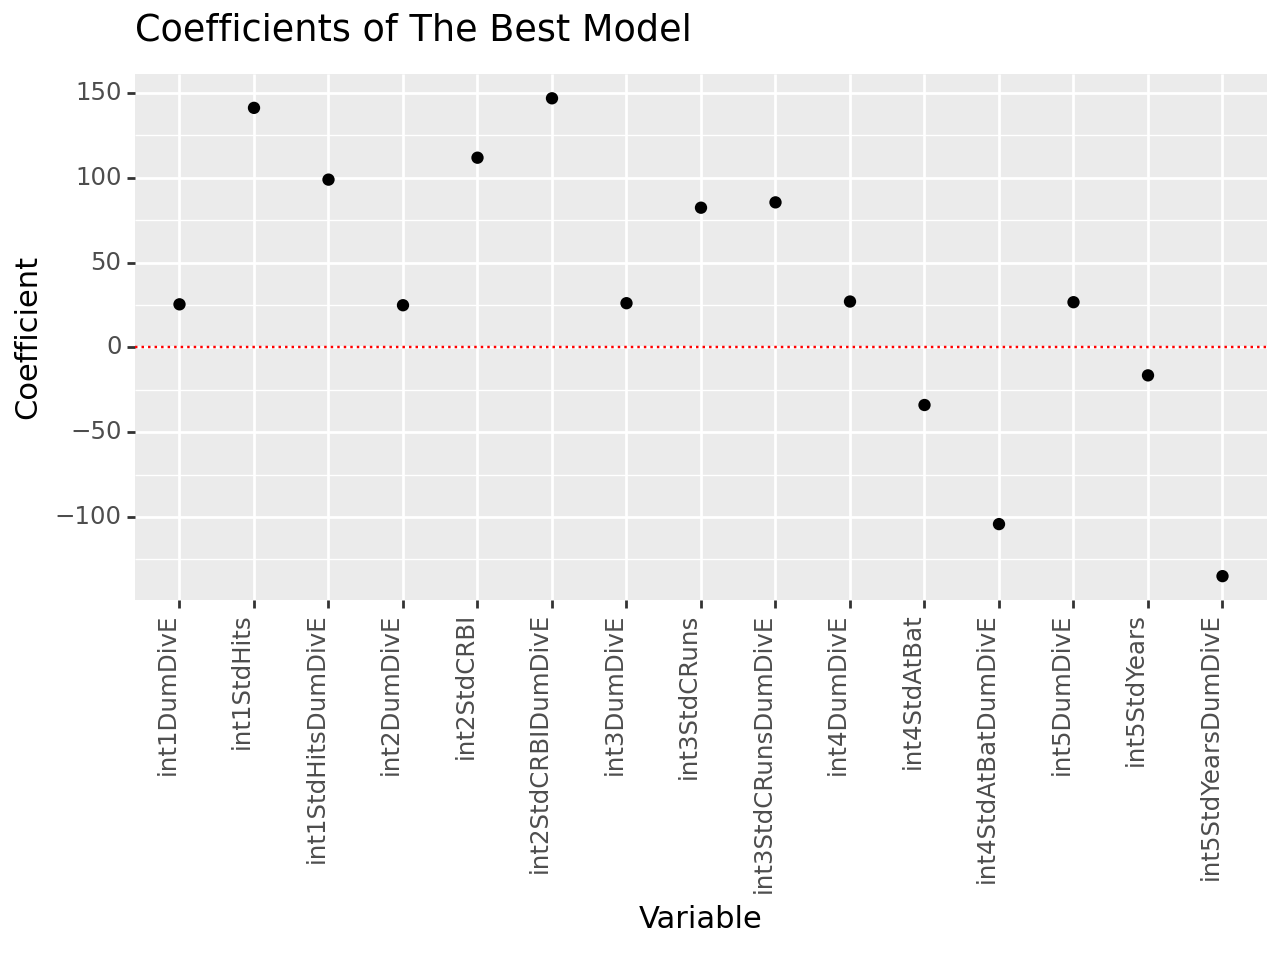

<Figure Size: (640 x 480)>

In [34]:
# Extract coefficients & var names
coefficients = best_pipeline.named_steps['enet_regression'].coef_

var_names = ct_inter.get_feature_names_out()

# Create a DataFrame
coef_df = pd.DataFrame({
    'Variable': var_names,
    'Coefficient': coefficients
})

# Filter out zero coefficients
coef_df = coef_df[coef_df['Coefficient'] != 0]

import pandas as pd

# Assuming your DataFrame is named coef_df
# Replace 'interaction' with 'int', remove underscores and spaces
coef_df['Variable'] = coef_df['Variable'].str.replace('interaction', 'int', regex=False)
coef_df['Variable'] = coef_df['Variable'].str.replace('Standardize', 'Std', regex=False)
coef_df['Variable'] = coef_df['Variable'].str.replace('dummify', 'Dum', regex=False)
coef_df['Variable'] = coef_df['Variable'].str.replace('Division', 'Div', regex=False)
coef_df['Variable'] = coef_df['Variable'].str.replace('[ _]', '', regex=True)

# Plot using plotnine
(ggplot(coef_df, aes(x='Variable', y='Coefficient'))
 + geom_point()
 + geom_hline(yintercept=0, color="red", linetype="dotted")
 + theme(axis_text_x=element_text(angle=90, hjust=1))
 + ggtitle('Coefficients of The Best Model'))


The model that was most successful used the previous variables we identified that had the largest coefficients across all types of models. They are Hits, CRBI, CRuns, Years, and Division.

It appears the interaction with CRBI and Division E have the greatest positive coefficient and the interaction between AtBat and Division E have the largest negative coefficient. This follows the earlier trends we saw in our previous models as CRBI was a major positive coefficient in each model, AtBats was a major negative coefficient, and Division E had the largest coefficient of all the categorical variables from the baseball dataset.